In [1]:
# some_file.py
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/home/zcapjru/PhD/DEScls')
from xcell.mappers import MappereBOSSQSO
from xcell.mappers import MapperP15CMBK

from astropy.io import fits
from astropy.table import Table

import pyccl as ccl
import numpy as np
import pylab as plt
import pymaster as nmt
import healpy as hp
from classy import Class
import pymc3 as pm
import theano.tensor as tt
import os

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
sys.path.insert(1, '/home/zcapjru/PhD/Pk_Emulator')

import scipy
import itertools
from numpy import linalg
from sklearn.decomposition import PCA

import lin_pk_emul as emul

In [3]:
# Initialize binning scheme with 20 ells per bandpower
nside = 512
nside_mask = 512

ells = []
i = 11.5
while i <= 3 * nside:
    ells.append(round(i))
    #i = i*(1+i/(3 * nside))
    i = i+20*(1+i/240)
    
if ells[-1] <  3 * nside -1:   
    ells.append(3 * nside -1)
    
ells = np.array(ells)

extened_ell_arr = np.arange(1, 3*nside)

scale_cut = 500
ells = ells[ells < scale_cut]

if ells[-1] < scale_cut:
    ells = np.append(ells, scale_cut)
    
bands = nmt.NmtBin.from_edges(ells[:-1], ells[1:])
ell_arr = bands.get_effective_ells()
print(ell_arr)

[ 21.5  43.   67.   92.5 120.  150.5 183.  218.  256.5 298.  343.  391.5
 444.  485.5]


In [4]:
NGC_1_config = {'data_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO/eBOSS_QSO_clustering_data-NGC-vDR16.fits'], 
          'random_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO/eBOSS_QSO_clustering_random-NGC-vDR16.fits'],
          'z_edges':[0, 1.5],
          'nside':nside, 'nside_mask': nside_mask, 'mask_name': 'mask_QSO_NGC_1' }

NGC_2_config = {'data_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO/eBOSS_QSO_clustering_data-NGC-vDR16.fits'], 
          'random_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO/eBOSS_QSO_clustering_random-NGC-vDR16.fits'],
          'z_edges':[1.5, 3],
          'nside':nside, 'nside_mask': nside_mask, 'mask_name': 'mask_QSO_NGC_2'  }

SGC_1_config = {'data_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO/eBOSS_QSO_clustering_data-SGC-vDR16.fits'], 
          'random_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO/eBOSS_QSO_clustering_random-SGC-vDR16.fits'],
          'z_edges':[0.01, 1.5],
          'nside':nside, 'nside_mask': nside_mask, 'mask_name': 'mask_QSO_SGC_1' }

SGC_2_config = {'data_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO/eBOSS_QSO_clustering_data-SGC-vDR16.fits'], 
          'random_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO/eBOSS_QSO_clustering_random-SGC-vDR16.fits'],
          'z_edges':[1.5, 3],
          'nside':nside, 'nside_mask': nside_mask, 'mask_name': 'mask_QSO_SGC_1'  }

CMBK_config = {'file_klm':'/home/zcapjru/PhD/Data/COM_Lensing_2048_R2.00/dat_klm.fits', 
          'file_mask':'/home/zcapjru/PhD/Data/COM_Lensing_2048_R2.00/mask.fits.gz',
               'file_noise':'/home/zcapjru/PhD/Data/COM_Lensing_2048_R2.00/nlkk.dat', 'mask_name': 3,
          'nside':nside}

In [5]:
b_arr = np.linspace(0, 5, 100)
zbin = 1
mode = 'SGC'
only_gg = False
only_gk = False
use_emulator = False
use_toeplitz = True
#use_pymc = True
cov_path = '/home/zcapjru/PhD/Covs/'

maps_k = MapperP15CMBK(CMBK_config)
maps_q = MappereBOSSQSO(SGC_1_config)

/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


In [6]:
pars = {
            'h':       0.67,
            'Omega_c': 0.27,
            'Omega_b': 0.045,
            'sigma8': 0.840,
            'n_s':     0.96,
            'w0': -1.0,
            'wa':  0.0
        }
param_dict = dict({'transfer_function': 'boltzmann_class'},
                          **pars)
cosmo = ccl.Cosmology(**param_dict)

nz = maps_q.get_nz()

z = nz[1]
dNdz = nz[0]

In [7]:
def get_cov_wsp(f1, f2, f3 = None, f4 = None, toeplitz = False):
    cw = nmt.NmtCovarianceWorkspace()
    if toeplitz:
        cw.compute_coupling_coefficients(f1, f2, f3, f4,  l_toeplitz=345, l_exact=100, dl_band=250)
    else:
        cw.compute_coupling_coefficients(f1, f2, f3, f4)
    return cw

def get_cov(cl1, cl2, cl3, cl4, cw, wa, wb):
    return  nmt.gaussian_covariance(cw,
                                      0, 0, 0, 0,  # Spins of the 4 fields
                                      cl1,  # TT
                                      cl2,  # TT
                                      cl3,  # TT
                                      cl4,  # TT
                                      wa, wb=wb)

In [8]:
%%time
m_q = maps_q.get_mask()
f_q = maps_q.get_nmt_field()

w_qq = nmt.NmtWorkspace()
w_qq.compute_coupling_matrix(f_q, f_q, bands)

#everything decoupled
nl_qq =  w_qq.decouple_cell(maps_q.get_nl_coupled())

cw_qq = get_cov_wsp(f_q, f_q, toeplitz = use_toeplitz)

cl_qq = nmt.compute_coupled_cell(f_q, f_q)/ np.mean(m_q * m_q)
cov_qqqq = get_cov(cl_qq, cl_qq, cl_qq, cl_qq, cw_qq, w_qq, w_qq)

err_qq = np.sqrt(cov_qqqq.diagonal())


m_k = maps_k.get_mask()
f_k = maps_k.get_nmt_field()

w_kq = nmt.NmtWorkspace()
w_kq.compute_coupling_matrix(f_q, f_k, bands)

w_kk = nmt.NmtWorkspace()
w_kk.compute_coupling_matrix(f_k, f_k, bands)

cw_qkqk = get_cov_wsp(f_q, f_k, toeplitz = use_toeplitz)
cw_qqqk = get_cov_wsp(f_q, f_q, f_q, f_k, toeplitz = use_toeplitz)

cl_qk = nmt.compute_coupled_cell(f_q, f_k)/ np.mean(m_q * m_k)
cl_kq = cl_qk
cl_kk = nmt.compute_coupled_cell(f_k, f_k)/ np.mean(m_k * m_k)
cov_qkqk = get_cov(cl_qq, cl_qk, cl_kq, cl_kk, cw_qkqk, w_kq, w_kq)

cov_qqqk = get_cov(cl_qq, cl_qk, cl_qq, cl_qk, cw_qqqk, w_qq, w_kq)

err_qk = np.sqrt(cov_qkqk.diagonal())

CPU times: user 5min 47s, sys: 21.7 s, total: 6min 9s
Wall time: 1min 7s


In [9]:
cl_qq = w_qq.decouple_cell(nmt.compute_coupled_cell(f_q, f_q))[0] - nl_qq[0]
cl_qk = w_kq.decouple_cell(nmt.compute_coupled_cell(f_q, f_k))[0] 
data = np.zeros(2*len(cl_qq))
data[:len(cl_qq)] =  cl_qq
data[len(cl_qq):] =  cl_qk

In [10]:
def build_comp_cov(cov_aaaa, cov_aaab, cov_aabb):
    cov_abaa = np.transpose(cov_aaab)
    dim = len(cov_aaaa)
    comp_cov = np.zeros([2*dim, 2*dim])
    comp_cov[:dim,:dim] = cov_aaaa
    comp_cov[:dim,dim:] = cov_aaab
    comp_cov[dim:,:dim] = cov_abaa
    comp_cov[dim:,dim:] = cov_aabb
    return comp_cov

In [11]:
comp_cov = build_comp_cov(cov_qqqq, cov_qqqk, cov_qkqk)

In [12]:
if use_emulator:
    emulator_100 = emul.LinPkEmulator(10, 200, 100, new=False )
    k_arr, pk0 = emulator_100.get_emulated_Pk(cosmo['Omega_c'],cosmo['h'])
    a_arr = np.linspace(0.01, 1, num=50)
    #pk = ccl.boltzmann.get_class_pk_lin(cosmo)
    D_arr = (1 + ccl.background.growth_factor(cosmo, a_arr)) ** 2
    
    pk_arr = [] 
    for item in D_arr:
        pk_arr.append(pk0*item)
    pk_arr = np.array(pk_arr).real
    
    pknew = ccl.Pk2D(a_arr = a_arr, lk_arr = k_arr, pk_arr = pk_arr,
                 cosmo=cosmo, is_logp=False)
    ccl.ccllib.cosmology_compute_linear_power(cosmo.cosmo, pknew.psp, 0)

In [13]:
def theory(b):
    b = b*np.ones(len(z))
    quasar = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z, dNdz), bias=(z,b))
    CMB_shear = ccl.CMBLensingTracer(cosmo, 1100)
    clgg = w_qq.decouple_cell(w_qq.couple_cell([ccl.angular_cl(cosmo, quasar, quasar, extened_ell_arr)]))[0]
    clgk = w_kq.decouple_cell(w_kq.couple_cell([ccl.angular_cl(cosmo, CMB_shear, quasar, extened_ell_arr)]))[0]
    theory = np.zeros(2*len(clgg))
    theory[:len(clgg)] = clgg
    theory[len(clgg):] = clgk
    return theory

def gof(b):
    inv_cov = np.linalg.inv(comp_cov)
    t = theory(b)
    if only_gg:
        data[int(len(data)/2):] = np.zeros(int(len(data)/2))
        t[int(len(data)/2):] = np.zeros(int(len(data)/2))  
    if only_gk:
        data[:int(len(data)/2)] = np.zeros(int(len(data)/2))
        t[:int(len(data)/2)] = np.zeros(int(len(data)/2)) 
    return np.transpose(data-t)@inv_cov@(data-t)

In [14]:
x2 = []
for item in b_arr:
    x2.append(gof(item))
x2 = np.array(x2)

pb = np.exp(-0.5*x2)
pb = pb/sum(pb)
best_b = b_arr[np.argmin(x2)]
best_x2 = min(x2)
mean_b = (sum(b_arr*pb))/(sum(pb))
sigma_b = np.sqrt((sum(np.abs(b_arr-mean_b)*pb))/(sum(pb)))
print(best_x2, best_b, mean_b, sigma_b)
print(len(data))

23.312288575080206 1.9696969696969697 1.9586977806844905 0.3225098753553628
28


In [15]:
best_b = best_b*np.ones(len(z))

quasar = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,dNdz), bias=(z,best_b))
CMB_shear = ccl.CMBLensingTracer(cosmo, 1100)

theory_qq = w_qq.decouple_cell(w_qq.couple_cell([ccl.angular_cl(cosmo, quasar, quasar, extened_ell_arr)]))[0]
theory_qk = w_kq.decouple_cell(w_kq.couple_cell([ccl.angular_cl(cosmo, CMB_shear, quasar, extened_ell_arr)]))[0]

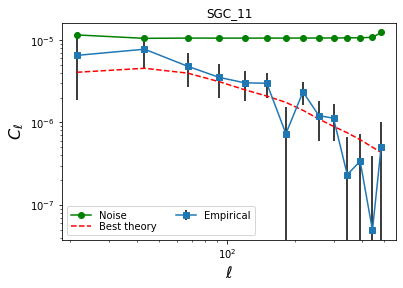

In [16]:
plt.errorbar(ell_arr, cl_qq, yerr=err_qq, marker='s', ecolor='k', label='Empirical')
plt.plot(ell_arr, nl_qq[0], 'go-', label='Noise')
plt.plot(ell_arr, theory_qq, 'r--', label='Best theory')


plt.loglog()
#plt.xlim((ell_arr[0], ell_arr[-1]))
plt.title('{}_{}{}'.format(mode, zbin, zbin))
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

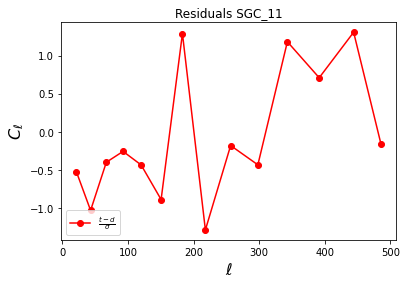

In [17]:
plt.plot(ell_arr, (theory_qq-cl_qq)/err_qq, 'ro-', label=r'$\frac{t-d}{\sigma}$')
#plt.loglog()
#plt.xlim((ell_arr[0], ell_arr[-1]))
plt.title('Residuals {}_{}{}'.format(mode, zbin, zbin))
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

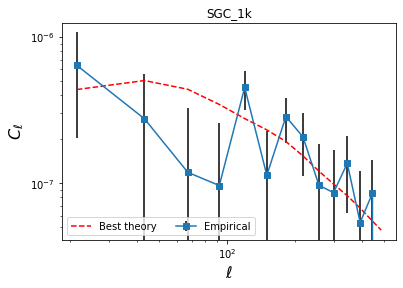

In [18]:
plt.errorbar(ell_arr, cl_qk, yerr=err_qk, marker='s', ecolor='k', label='Empirical')
plt.plot(ell_arr, theory_qk, 'r--', label='Best theory')


plt.loglog()
#plt.xlim((ell_arr[0], ell_arr[-1]))
plt.title('{}_{}{}'.format(mode, zbin, 'k'))
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

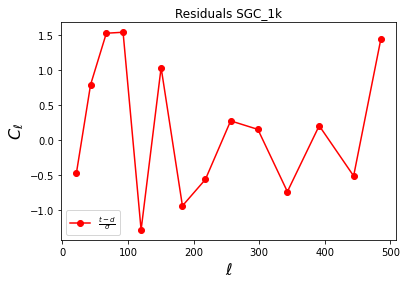

In [19]:
plt.plot(ell_arr, (theory_qk-cl_qk)/err_qk, 'ro-', label=r'$\frac{t-d}{\sigma}$')

#plt.loglog()
#plt.xlim((ell_arr[0], ell_arr[-1]))
plt.title('Residuals {}_{}{}'.format(mode, zbin, 'k'))
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

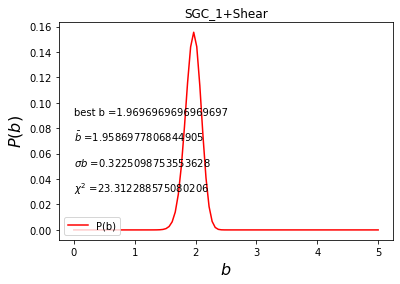

In [20]:
plt.plot(b_arr, pb, 'r-', label='P(b)')
plt.text(0, 0.09, 'best b ='+'{}'.format(best_b[0]))
plt.text(0, 0.07, r'$\bar{b}$ ='+'{}'.format(mean_b))
plt.text(0, 0.05, r'$\sigma b$ ='+'{}'.format(sigma_b))
plt.text(0, 0.03, r'$\chi^2$ ='+'{}'.format(best_x2))
plt.title('{}_{}+Shear'.format(mode, zbin))
plt.xlabel('$b$', fontsize=16)
plt.ylabel('$P(b)$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()